In [1]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import requests

In [2]:
import certs

#bucket = '<s3-bucket-name>'
bucket = certs.bucket

#model_id = '<dmm-model-id>'
#model_id = certs.model_id

In [3]:
#daily_data_path = '/mnt/data/CustomerChurn46/DailyData/'

#dmm_api_key = os.environ.get('DMM_API_TOKEN')
#dmm_api_key = certs.dmm_api_key

#print(dmm_api_key)

In [4]:
#Bring in data used to train pickled model that is loaded in later
df = pd.read_csv('/mnt/code/Test&TrainData/ChurnTrainingDataPP.csv')
df.drop('predictionProbability', axis =1,inplace = True)
print(df.shape)
df.head()

(7939, 7)


,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,844336,0.016364,550,28,89.2,45,0
1,146041,0.018349,545,33,54.2,43,0
2,847745,0.018519,378,41,55.3,41,0
3,285565,0.014493,552,32,66.8,31,0
4,754611,0.012132,577,4,87.2,43,0


In [5]:
#append data to istelf to double volume
df2 = df.append(df)

In [6]:
#Reset custid field so that there are no repeats
df2['custid'] = np.random.choice(range(df.custid.min(), df.custid.max()),df2.shape[0], replace=False)

In [7]:
##For each input feature adjust data and round/cast as necessary
#dropperc - 50%-150%
droppJitter = df2.dropperc.apply(lambda x : x*(random.randrange(50,150))/100)
#mins - 70%-130%
minsJitter = df2.mins.apply(lambda x : x*(random.randrange(70,130)/100)).round(0).astype(int)
#consecMonths - 80%-120%
consecMonthsJitter = df2.consecmonths.apply(lambda x : x*(random.randrange(80,120)/100)).round(0).astype(int)
#Income - 40%-160%
incomeJitter = df2.income.apply(lambda x : x*(random.randrange(40,160)/100)).round(1)
#age - 90%-110%
ageJitter = df2.age.apply(lambda x : x*(random.randrange(90,110)/100)).round(0).astype(int)


In [8]:
#Take all the new 'jittered' variables and write to a new df
#Keep original custid and churn_Y fields
df3 = pd.DataFrame({'custid': df2.custid,
       'dropperc': droppJitter, 
       'mins': minsJitter,
       'consecmonths': consecMonthsJitter,
       'income': incomeJitter,
       'age': ageJitter,
       'churn_Y': df2.churn_Y
                   })

In [9]:
df3.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
0,53853,0.015709,654,30,51.7,41,0
1,200757,0.027156,474,36,62.3,46,0
2,111577,0.023889,465,36,62.5,37,0
3,737469,0.011014,513,36,76.2,30,0
4,64001,0.010919,594,3,54.9,44,0


In [10]:
#Understand correlations between new jittered data and original
#Should see larger data drift for lower correlations
concatset = pd.concat([df2,df3], axis =1)
concatset.columns=(list(df2.columns)+list('Jittered_'+df3.columns))
print('Correlations between original and altered vars -')
for i,k in enumerate(df2.columns):
    print('{}: {}'.format(k, concatset.corr()[k]['Jittered_'+k].round(4)))


Correlations between original and altered vars -
custid: 1.0
dropperc: 0.7306
mins: 0.7403
consecmonths: 0.9299
income: 0.6182
age: 0.9691
churn_Y: 1.0


In [11]:
#Load in trained model object    
loaded_model = pickle.load(open('/mnt/code/models/ChurnBinaryClassifier.pkl', 'rb'))

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator AdaBoostClassifier from version 0.22.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
#Grab between 100 and 500 random rows from jittered data
df_inf = df3.sample(n = random.randint(100,500))
print(df_inf.shape[0], "records selected for sample")
df_inf.head()

293 records selected for sample


,custid,dropperc,mins,consecmonths,income,age,churn_Y
3755,774351,0.021010,402,36,75.6,47,0
1834,438674,0.019779,429,21,112.4,52,0
4120,784330,0.018610,698,20,50.0,47,0
7909,565895,0.018765,617,40,111.3,55,0
1223,913310,0.034198,530,12,46.1,40,0


In [13]:
#Save input features
X = df_inf.loc[:, 'dropperc':'age']
print(f"shape of X is {X.shape}")
X.head()

shape of X is (293, 5)


,dropperc,mins,consecmonths,income,age
3755,0.021010,402,36,75.6,47
1834,0.019779,429,21,112.4,52
4120,0.018610,698,20,50.0,47
7909,0.018765,617,40,111.3,55
1223,0.034198,530,12,46.1,40


In [14]:
#Get model predictions for the sample of input features defined above
predictions = loaded_model.predict(X)
#Get model prediction probabilities for the sample of input features defined above
probas = loaded_model.predict_proba(X).tolist() # I added tolist here
print(f"lenght of probas is {len(probas)}")
probas[:4]

lenght of probas is 293


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


[[0.5393561017590117, 0.4606438982409882],
 [0.5915810704662712, 0.4084189295337289],
 [0.7601891661721021, 0.23981083382789795],
 [0.5465650051484342, 0.45343499485156574]]

In [15]:
df_inf.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
3755,774351,0.021010,402,36,75.6,47,0
1834,438674,0.019779,429,21,112.4,52,0
4120,784330,0.018610,698,20,50.0,47,0
7909,565895,0.018765,617,40,111.3,55,0
1223,913310,0.034198,530,12,46.1,40,0


In [16]:
#write ground truth data out
churn_groundTruth = pd.DataFrame(df_inf[['custid','churn_Y']]).rename(columns = {'churn_Y': 'y_gt'})
churn_groundTruth.head()

,custid,y_gt
3755,774351,0
1834,438674,0
4120,784330,0
7909,565895,0
1223,913310,0


In [17]:
#Create data set with predictions and pred probabilities
preds_df = pd.DataFrame(data=predictions, columns=['churn_Y'], index=churn_groundTruth.index)
preds_df['predictionProbability']= tuple(probas)
preds_df

,churn_Y,predictionProbability
3755,0,"[0.5393561017590117, 0.4606438982409882]"
1834,0,"[0.5915810704662712, 0.4084189295337289]"
4120,0,"[0.7601891661721021, 0.23981083382789795]"
7909,0,"[0.5465650051484342, 0.45343499485156574]"
1223,0,"[0.6997601531901843, 0.30023984680981575]"
...,...,...
2094,0,"[0.5726431413805482, 0.4273568586194519]"
2369,0,"[0.5665763456701025, 0.4334236543298976]"
2729,0,"[0.5765740711792867, 0.42342592882071317]"
6050,0,"[0.5524669986908519, 0.447533001309148]"


In [18]:
#x_preds_df=preds_df.predictionProbability.apply(lambda x : str(x))
#x_preds_df.head()
#preds_df['predictionProbability'] = preds_df['predictionProbability'].str.title()

In [19]:
preds_df.head()

,churn_Y,predictionProbability
3755,0,"[0.5393561017590117, 0.4606438982409882]"
1834,0,"[0.5915810704662712, 0.4084189295337289]"
4120,0,"[0.7601891661721021, 0.23981083382789795]"
7909,0,"[0.5465650051484342, 0.45343499485156574]"
1223,0,"[0.6997601531901843, 0.30023984680981575]"


In [20]:
x2_preds_df=preds_df.churn_Y.apply(lambda x : str(x))
x2_preds_df.head()

3755    0
1834    0
4120    0
7909    0
1223    0
Name: churn_Y, dtype: object

In [21]:
#adjust format of pred probabilities
#x_preds_df=preds_df.predictionProbability.apply(lambda x : str(x).replace('(', '[').replace(')', ']'))
#x_preds_df.head()

In [22]:
df_inf.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y
3755,774351,0.021010,402,36,75.6,47,0
1834,438674,0.019779,429,21,112.4,52,0
4120,784330,0.018610,698,20,50.0,47,0
7909,565895,0.018765,617,40,111.3,55,0
1223,913310,0.034198,530,12,46.1,40,0


In [23]:
#join prediction and prob data with input features dropping churn_Y
churn_inputs_and_preds = df_inf.drop('churn_Y', axis =1)\
.join(preds_df, how = 'inner').drop_duplicates(subset = 'custid')

In [24]:
#Create 'protected class' feature to monitor for disparity in target distribution
churn_inputs_and_preds['Gender']=np.random.randint(0,3, churn_inputs_and_preds.shape[0])
mymap = {0:'M',1: 'F', 2: 'NB'}
churn_inputs_and_preds['Gender'] = churn_inputs_and_preds['Gender'].apply(lambda x: mymap.get(x))
churn_inputs_and_preds.head()

,custid,dropperc,mins,consecmonths,income,age,churn_Y,predictionProbability,Gender
38,107234,0.010258,641,29,47.0,48,0,"[0.7023729632754047, 0.2976270367245953]",NB
64,771011,0.016364,454,19,45.8,51,0,"[0.6072108634434678, 0.3927891365565323]",NB
127,413798,0.017255,565,26,38.0,50,0,"[0.5694840525825424, 0.4305159474174576]",NB
299,720099,0.018440,284,25,74.2,55,0,"[0.5764791543097114, 0.4235208456902885]",M
311,928473,0.018307,585,39,61.0,52,0,"[0.5540807406205471, 0.44591925937945287]",F


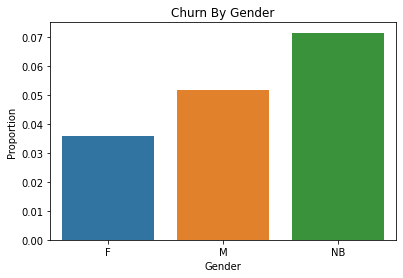

In [25]:
#Add visualization of protected class for tracking purposes
ax = sns.barplot(x = ['F', 'M', 'NB'], y = churn_inputs_and_preds.groupby('Gender').mean()['churn_Y'])

ax.set_title('Churn By Gender')
ax.set_ylabel('Proportion')
ax.set_xlabel('Gender')
fig = ax.get_figure()
fig.set_size_inches(12,4)
plt.gcf().subplots_adjust(left=0.5)

fig.savefig('/mnt/code/Viz/protected_class_monitoring.png')

In [26]:
## Run two checks below to validate input and GT data is of same size and contains same custIDs

lenCheck = churn_inputs_and_preds.shape[0]==churn_groundTruth.shape[0]
print('Length Check Pass:', lenCheck)

idCheck= (churn_inputs_and_preds.custid.sort_values()==churn_groundTruth.custid.sort_values())\
.sum() ==churn_inputs_and_preds.shape[0]
print('ID Check Pass:', idCheck)

Length Check Pass: True
ID Check Pass: True


In [27]:
churn_inputs_and_preds.shape

(293, 9)

In [28]:
churn_groundTruth.shape

(293, 2)

In [29]:
#Write input and pred data to DailyData folder # ---> this is the ground truth
#daily_data_path = '/mnt/CustomerChurn46/DailyData/'

#daily_data_path = '/mnt/CustomerChurn46/DailyData/'
daily_data_path = '/mnt/code/DailyData/'

input_and_pred_path = str(daily_data_path+'inputs_and_preds_'+str(datetime.date.today())+'.csv')
churn_inputs_and_preds.to_csv(input_and_pred_path, index = False)

In [30]:
#Write GT data to DailyData folder
ground_truth_path = str(daily_data_path+'ground_truth_'+str(datetime.date.today())+'.csv')
churn_groundTruth.to_csv(ground_truth_path, index = False)

In [31]:
import upload_to_s3
#Upload input&pred data and GT data to s3 bucket 
upload_to_s3.upload(input_and_pred_path, bucket)
upload_to_s3.upload(ground_truth_path, bucket)

inputs_and_preds_2022-05-05.csv Upload Successful
ground_truth_2022-05-05.csv Upload Successful


True

## At this point we are done with s3

In [ ]:
#Define file names for payload construction below
inputs_file_name = str('inputs_and_preds_'+str(datetime.date.today())+'.csv')
ground_truth_file_name = str('ground_truth_'+str(datetime.date.today())+'.csv')

In [ ]:
#Define api endpoint # Adding dmm model ID
inputs_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/prediction".format(model_id)

In [ ]:
inputs_file_name

In [ ]:
#Create inputs and prediction data payload
inputs_payload = """
{{
"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(inputs_file_name)

In [ ]:
#Set up call headers  # Adding dmm_api_key
headers = {
           'X-DMM-API-KEY': dmm_api_key,
           'Content-Type': 'application/json'
          }

In [ ]:
#Make API call # importing requests
inputs_response = requests.request("PUT", inputs_url, headers=headers, data = inputs_payload)

In [ ]:
#create GT payload    
ground_truth_payload = """
{{

"datasetDetails": {{
        "name": "{0}",
        "datasetType": "file",
        "datasetConfig": {{
            "path": "{0}",
            "fileFormat": "csv"
        }},
        "datasourceName": "churn-dmm-46",
        "datasourceType": "s3"
    }}
}}
""".format(ground_truth_file_name)

In [ ]:
#Define api endpoint
ground_truth_url = "https://demo.dominodatalab.com/model-monitor/v2/api/model/{}/register-dataset/ground_truth".format(model_id)

In [ ]:
#Make api call
ground_truth_response = requests.request("PUT", ground_truth_url, headers=headers, data = ground_truth_payload)

In [ ]:
#Print response
print(ground_truth_response.text.encode('utf8'))